# Filter posts on the reddit related to the ***COVID-19***

python=3.7

(time：March 1, 2020 to February 28 2022)

In [3]:
import pandas as pd
from joblib import Parallel, delayed  # parallel computing
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# show all columns in the DataFrame
pd.set_option('display.max_columns', None)
# fully display the content in displayed table cells
pd.set_option('display.max_colwidth', None)

## Use keywords to select comments related to ***COVID-19***

In [ ]:
# Filtering using topic keywords
import os
import re
from datetime import datetime
import pandas as pd
from multiprocessing import Pool

# keywords
keywords = ['wuhanpneumonia','COVID19','coronavirus','corona virus','2019-nCoV','SARS-CoV-2']

# file path
source_path = "/mnt/data/reddit/reddit/RC/"
target_path = "data/csv_filtered/"

# set time range
start_date = datetime.strptime("2020-03", "%Y-%m")
end_date = datetime.strptime("2022-02", "%Y-%m")

# settings for result filename
label = 'en+COVID19'
content = 'comment'

# format of source filename
date_str_pattern = r'RC_(.*?)\.zst\.csv'

# other settings
chunksize = 1e6
proc_num = 13

def process_file(source_name):
    # check file name
    mtch = re.search(date_str_pattern, source_name)
    if mtch:
        # get date from file name
        date_str = mtch.group(1)
        file_date = datetime.strptime(date_str, '%Y-%m')
        
        # check if the date in time range. if yes, process the file.
        if start_date <= file_date <= end_date:
            print(f"processing {source_name} ... ...\n", end='')
            target_name = f"{content}[{label}][{date_str}].csv"

            # check if the target file already exists
            if os.path.exists(target_path + target_name):
                print(f"{target_name} already exists.\n", end='')
                return

            try:
                for chunk in pd.read_csv(source_path + source_name, chunksize=chunksize, engine='python'):
                    df = chunk[chunk['body'].astype(str).str.contains('|'.join(keywords), case=False)]
                    df.to_csv(target_path + target_name, mode='a', index=False)
                print(f"{source_name} processed.\n", end='')
            except Exception as e:
                print(f"failed processing {source_name}.\n{e}\n", end='')

# get a list of files
files = os.listdir(source_path)

# create a pool of workers
with Pool(processes=proc_num) as pool:
    pool.map(process_file, files)

print("Done.")

In [3]:
import os

folder_path = 'data/csv_filtered'
all_data = pd.DataFrame()

# os.listdir()方法用于返回指定的文件夹包含的文件或文件夹的名字的列表
for filename in os.listdir(folder_path):
    # 使用os.path.join()方法拼接文件的完整路径
    file_path = os.path.join(folder_path, filename)
    # 使用os.path.isfile()方法判断路径是否为文件
    if os.path.isfile(file_path) and filename.endswith('.csv'):
        print(file_path)
        df = pd.read_csv(file_path, engine='python')
        all_data = all_data.append(df, ignore_index=True)

all_data.info()

data/csv_filtered/comment[en+COVID19][2020-05].csv
data/csv_filtered/comment[en+COVID19][2021-09].csv
data/csv_filtered/comment[en+COVID19][2021-05].csv
data/csv_filtered/comment[en+COVID19][2020-09].csv
data/csv_filtered/comment[en+COVID19][2020-03].csv
data/csv_filtered/comment[en+COVID19][2021-07].csv
data/csv_filtered/comment[en+COVID19][2021-10].csv
data/csv_filtered/comment[en+COVID19][2021-03].csv
data/csv_filtered/comment[en+COVID19][2021-02].csv
data/csv_filtered/comment[en+COVID19][2021-06].csv
data/csv_filtered/comment[en+COVID19][2020-04].csv
data/csv_filtered/comment[en+COVID19][2020-11].csv
data/csv_filtered/comment[en+COVID19][2022-01].csv
data/csv_filtered/comment[en+COVID19][2020-12].csv
data/csv_filtered/comment[en+COVID19][2021-11].csv
data/csv_filtered/comment[en+COVID19][2021-08].csv
data/csv_filtered/comment[en+COVID19][2020-08].csv
data/csv_filtered/comment[en+COVID19][2020-07].csv
data/csv_filtered/comment[en+COVID19][2020-06].csv
data/csv_filtered/comment[en+CO

In [4]:
# considering four possibilities
df=all_data.query("author !='[deleted]' & body!='[deleted]'")
df=all_data.query("author !='[removed]' & body!='[deleted]'")
df=all_data.query("author !='[removed]' & body!='[removed]'")
df=all_data.query("author !='[deleted]' & body!='[removed]'")

In [6]:
len(df)

5670890

In [5]:
# language detection
from langdetect import detect
def detectlang(x):
    try:
        return (detect(x))
    except:
        return ''

from pandarallel import pandarallel
# Initialization
pandarallel.initialize(progress_bar=True, nb_workers=32)
# Parallel apply
df['lang'] = df['body'].parallel_apply(detectlang).tolist()

df.to_csv('data/comments[topic=COVID19][lang=en].csv',index=None)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
# check the number of language types
unique_lang_count = df['lang'].value_counts()
unique_lang_count.head(10)

en    5270472
        84086
es      60894
de      36660
pt      33945
fr      32457
cy      25647
it      22718
nl      14517
ro      10577
Name: lang, dtype: int64

## Based on previous selection, use debunking keywords for filtering

In [9]:
df = pd.read_csv("data/comments[topic=COVID19][lang=en].csv")

# English debunking keywords
debunk_keywords_en = [
    'fact check', 'fact-checking', 'fact checkers', 'fake news', 'misinformation', 'disinformation', 
    'debunkers', 'debunker', 'debunking', 'debunk'
]

# get more debunking key words
debunk_site = pd.read_csv("data/(Merge_ver3)debunking_fact-checking_sites.csv")
debunk_site = debunk_site.dropna(subset=['domain'])
debunk_site_domain = debunk_site['domain'].to_list()
debunk_site_name = debunk_site['name'].to_list()

df_debunk_en = df[
    (df['lang'] == 'en') &  # '&' has higher priority than '=='
    df['body'].astype(str).str.contains('|'.join(debunk_keywords_en + debunk_site_domain + debunk_site_name), case=False)
]

df_debunk_en.sort_values('created_utc', inplace=True)
df_debunk_en.to_csv("data/debunking_comments[topic=COVID19][lang=en].csv", index=False)

In [10]:
df_debunk_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290318 entries, 875637 to 5407358
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   created_utc   290318 non-null  object
 1   author        290318 non-null  object
 2   subreddit     290318 non-null  object
 3   body          290318 non-null  object
 4   parent_id     290318 non-null  object
 5   subreddit_id  290318 non-null  object
 6   id            290318 non-null  object
 7   lang          290318 non-null  object
dtypes: object(8)
memory usage: 19.9+ MB


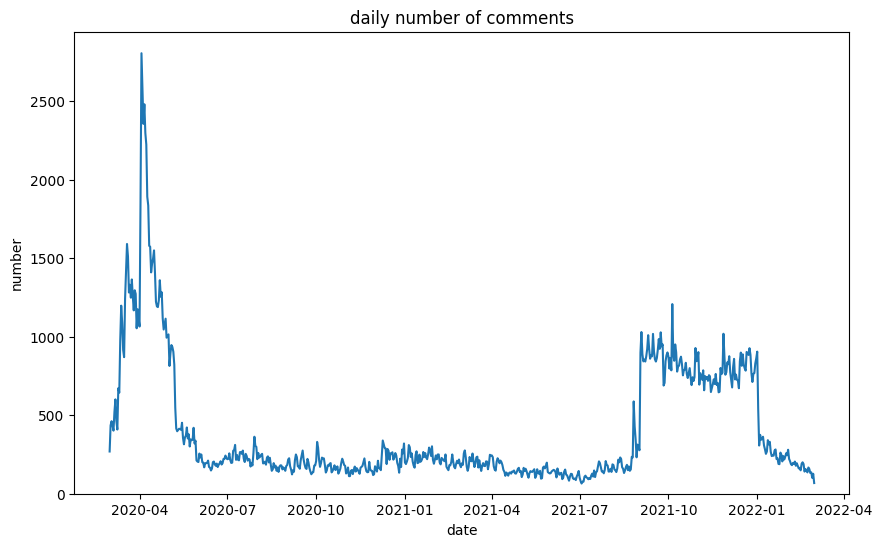

In [6]:
# 作出按日变化的帖子数统计图
df = pd.read_csv("data/debunking_comments[topic=COVID19][lang=en].csv")

df['created_utc'] = pd.to_datetime(df['created_utc'])
df['date'] = df['created_utc'].dt.date  # 创建一个新列，只包含日期信息

# 创建一个日期范围，从最早的帖子日期到最晚的帖子日期
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())
# 对日期进行分组，并计算每组的大小（即每天的数据条数）
daily_counts = df.groupby('date').size()  
# 使用reindex函数来填充缺失的日期，对于缺失的日期，帖子数量设为0
daily_counts = daily_counts.reindex(date_range, fill_value=0)

plt.figure(figsize=(10, 6))

sns.lineplot(data=daily_counts)

plt.title('daily number of comments')
plt.ylim((0,None))
plt.xlabel('date')
plt.ylabel('number')
plt.show()